In [49]:
# magic for Jupyter
%matplotlib inline

#import the read_block function from the tdt package
#also import other python packages we care about
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt  # standard Python plotting library
import scipy.stats as stats

import tdt


In [50]:
blockpath = r'N:\2024April_May_Tanks_GRBDA_RI\Day8_RI30_05012024\WTY\RI4_EN4_010124-240501-135454'
data = tdt.read_block(blockpath) # created a dictionary to read
isosbestic = '_415A'
dopa='_465A'

read from t=0s to t=1799.09s


In [51]:
#setting up variable names for the data I want to get out of the tank for this
REF_EPOC     = 'RNP_'
isosbestic
dopa
STREAM_STORE = '_465A'   #seems to be having trouble finding this later on?
ARTIFACT     = np.inf       # optionally set an artifact rejection level (figure out what this actually does)
CHANNEL      = 1
TRANGE       = [-5, 10]  # window size [start time relative to epoc onset, window duration]
BASELINE_PER = [-5, 0]

In [52]:
data = tdt.read_block(blockpath, evtype=['epocs','streams'], channel=CHANNEL)

read from t=0s to t=1799.09s


In [53]:
data = tdt.epoc_filter(data, 'RNP_', t=TRANGE)  #filters the chosen epocs (RNP_) and time set around those epocs

In [54]:
data['epocs']['RNP_']

name:	'RNP_'
onset:	array([  30.1187072 ,  139.57316608,  147.57543936,  310.9093376 ,
        478.57958912,  507.6197376 ,  521.65738496,  560.29495296,
        683.73282816,  755.64367872,  962.92274176,  979.81431808,
       1006.50369024, 1021.27337472, 1099.8628352 , 1150.93110784,
       1177.92423936, 1262.37540352, 1365.49482496, 1416.85653504,
       1501.73515776, 1517.37827328, 1619.34524416, 1671.78207232])
offset:	array([ 139.57316608,  147.57543936,  310.9093376 ,  478.57958912,
        507.6197376 ,  521.65738496,  560.29495296,  683.73282816,
        755.64367872,  962.92274176,  979.81431808, 1006.50369024,
       1021.27337472, 1099.8628352 , 1150.93110784, 1177.92423936,
       1262.37540352, 1365.49482496, 1416.85653504, 1501.73515776,
       1517.37827328, 1619.34524416, 1671.78207232,           inf])
type:	'onset'
type_str:	'epocs'
data:	array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])
dform:	4
size:	10

In [55]:
# Optionally remove artifacts. If any waveform is above ARTIFACT level, or
# below -ARTIFACT level, remove it from the data set.
total1 = np.size(data['streams'][dopa].filtered)
total2 = np.size(data['streams'][isosbestic].filtered)

# List comprehension checking if any single array in 2D filtered array is > Artifact or < -Artifact
data['streams'][dopa].filtered = [x for x in data['streams'][dopa].filtered 
                                if not np.any(x > ARTIFACT) or np.any(x < -ARTIFACT)]
data['streams'][isosbestic].filtered = [x for x in data['streams'][isosbestic].filtered 
                               if not np.any(x > ARTIFACT) or np.any(x < -ARTIFACT)]

# Get the total number of rejected arrays
bad1 = total1 - np.size(data['streams'][dopa].filtered)
bad2 = total2 - np.size(data['streams'][isosbestic].filtered)
total_artifacts = bad1 + bad2


c:\Users\Tischfield\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size


In [56]:
# More examples of list comprehensions
min1 = np.min([np.size(x) for x in data['streams'][dopa].filtered])
min2 = np.min([np.size(x) for x in data['streams'][isosbestic].filtered])
data['streams'][dopa].filtered = [x[1:min1] for x in data['streams'][dopa].filtered]
data['streams'][isosbestic].filtered = [x[1:min2] for x in data['streams'][isosbestic].filtered]

# Downsample and average 10x via a moving window mean
N = 10 # Average every 10 samples into 1 value
F415 = []
F465 = []
for lst in data['streams'][isosbestic].filtered: 
    small_lst = []
    for i in range(0, min2, N):
        small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
    F415.append(small_lst)

for lst in data['streams'][dopa].filtered: 
    small_lst = []
    for i in range(0, min1, N):
        small_lst.append(np.mean(lst[i:i+N-1]))
    F465.append(small_lst)

#Create a mean signal, standard error of signal, and DC offset
meanF415 = np.mean(F415, axis=0)
stdF415 = np.std(F415, axis=0)/np.sqrt(len(data['streams'][isosbestic].filtered))
dcF415 = np.mean(meanF415)
meanF465 = np.mean(F465, axis=0)
stdF465 = np.std(F465, axis=0)/np.sqrt(len(data['streams'][dopa].filtered))
dcF465 = np.mean(meanF465)


In [57]:
# Create the time vector for each stream store
ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N

# Subtract DC offset to get signals on top of one another
meanF415 = meanF415 - dcF415
meanF465 = meanF465 - dcF465

# Start making a figure with 3 subplots
# First plot is the 405 and 465 averaged signals
fig = plt.figure(figsize=(9, 14))
ax0 = fig.add_subplot(311) # work with axes and not current plot (plt.)

# Plotting the traces
p1, = ax0.plot(ts1, meanF465, linewidth=2, color='green', label='465nm')
p2, = ax0.plot(ts2, meanF415, linewidth=2, color='blueviolet', label='415nm')

# Plotting standard error bands
p3 = ax0.fill_between(ts1, meanF465+stdF465, meanF465-stdF465,
                      facecolor='green', alpha=0.2)
p4 = ax0.fill_between(ts2, meanF415+stdF415, meanF415-stdF415,
                      facecolor='blueviolet', alpha=0.2)

# Plotting a line at t = 0
p5 = ax0.axvline(x=0, linewidth=3, color='slategray', label='Rewarded Magazine Entry')

# Plotting a line at mV = 0

p6 = ax0.axhline(y=0, linewidth=1, color='slategray')

# Finish up the plot
ax0.set_xlabel('Seconds')
ax0.set_ylabel('mV')
ax0.set_title('EN99 FR1 D4, %i Events (%i Artifacts Removed)'
              % (len(data['streams'][dopa].filtered), total_artifacts))
ax0.legend(handles=[p1, p2, p5], loc='upper right')
ax0.set_ylim(min(np.min(meanF465-stdF465), np.min(meanF415-stdF415)),
             max(np.max(meanF465+stdF465), np.max(meanF415+stdF415)))
ax0.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0]);

plt.close()
 # Jupyter cells will output any figure calls made, so if you don't want to see it just yet, close existing axis
            # https://stackoverflow.com/questions/18717877/prevent-plot-from-showing-in-jupyter-notebook
            # Note that this is not good code practice - Jupyter lends it self to these types of bad workarounds 

# Graph 1



In [58]:
ts2

array([-4.9901696, -4.9803392, -4.9705088, ...,  4.9876862,  4.9975166,
        5.007347 ])

In [59]:
Y_fit_all = []
Y_dF_all = []
for x, y in zip(F415, F465):
    x = np.array(x)
    y = np.array(y)
    bls = np.polyfit(x, y, 1)
    fit_line = np.multiply(bls[0], x) + bls[1]
    Y_fit_all.append(fit_line)
    Y_dF_all.append(y-fit_line)

# Getting the z-score and standard error
zall = []
for dF in Y_dF_all: 
   ind = np.where((np.array(ts2)<BASELINE_PER[1]) & (np.array(ts2)>BASELINE_PER[0]))
   zb = np.mean(dF[ind])
   zsd = np.std(dF[ind])
   zall.append((dF - zb)/zsd)

zerror = np.std(zall, axis=0)/np.sqrt(np.size(zall, axis=0))


In [60]:
ax1 = fig.add_subplot(312)
cs = ax1.imshow(zall, cmap=plt.cm.YlGnBu, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(data['streams'][dopa].filtered)])
cbar = fig.colorbar(cs, pad=0.01, fraction=0.02)
#ylabel_list = np.arange(len(zall), step = np.rint(len(zall)/4))
#ax1.set_yticks(ylabel_list)
ax1.set_title('EN99 FR1 D4 Individual z-Score Traces')
ax1.set_ylabel('Events')
ax1.set_xlabel('Seconds from Rewarded Mag (t = 0)')

plt.close()
# Suppress figure output again

#Graph 2

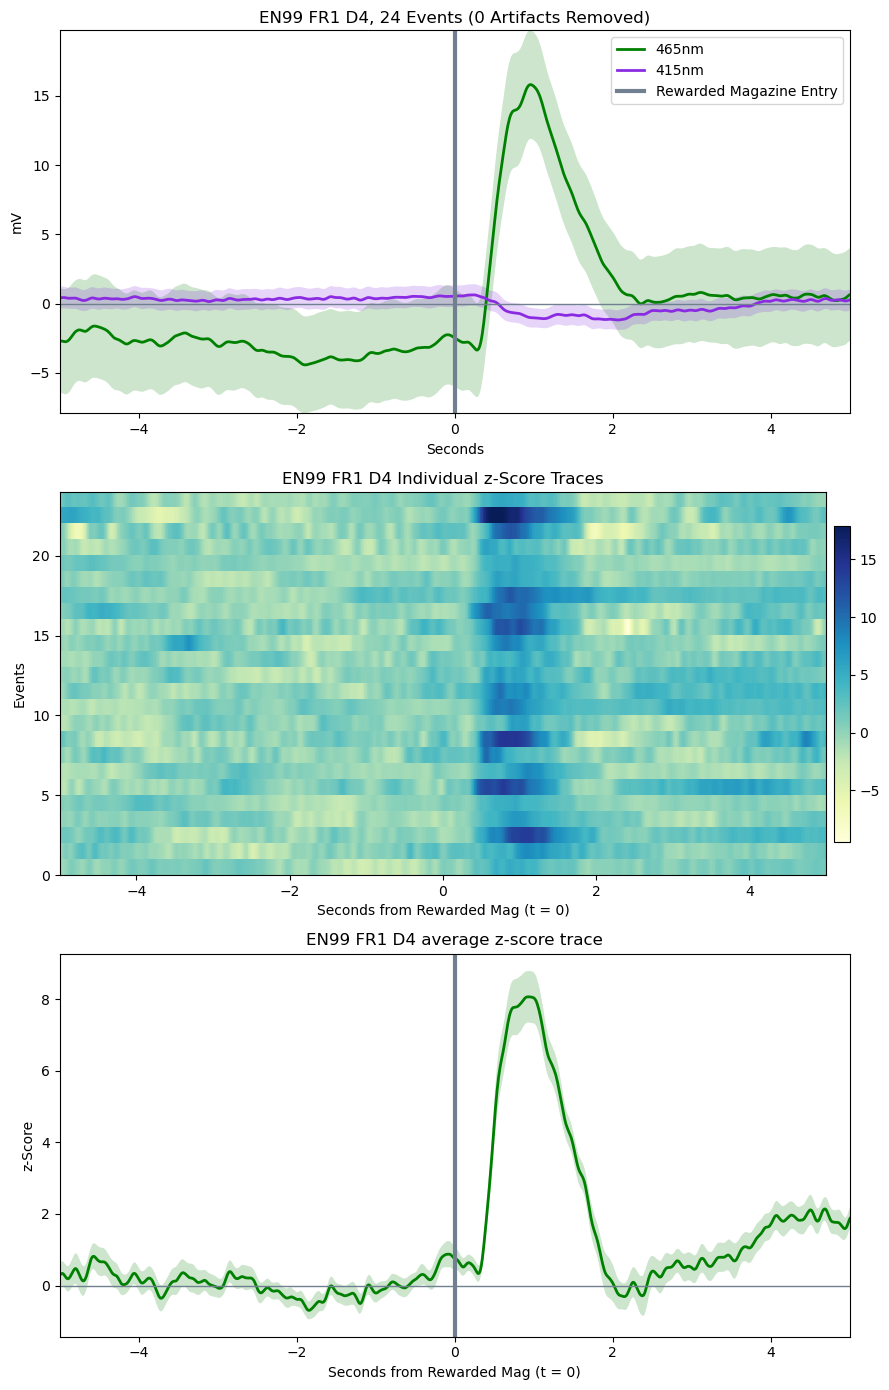

In [61]:
ax2 = fig.add_subplot(313)
p6 = ax2.plot(ts2, np.mean(zall, axis=0), linewidth=2, color='green', label='465nm')
p7 = ax2.fill_between(ts1, np.mean(zall, axis=0)+zerror
                      ,np.mean(zall, axis=0)-zerror, facecolor='green', alpha=0.2)
p8 = ax2.axvline(x=0, linewidth=3, color='slategray', label='Rewarded Magazine Entry')
p9 = ax2.axhline(y=0, linewidth=1, color='slategray')
#ax2.set_ylim([-2, 5])
ax2.set_ylabel('z-Score')
ax2.set_xlabel('Seconds from Rewarded Mag (t = 0)')
ax2.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0])
ax2.set_title('EN99 FR1 D4 average z-score trace')

plt.close()
fig.tight_layout()
fig
 #Graph 3

In [62]:
# AUC = [] # cue, shock
# ind1 = np.where((np.array(ts2)<-3) & (np.array(ts2)>-5))
# AUC1= auc(ts2[ind1], np.mean(zall, axis=0)[ind1])
# ind2 = np.where((np.array(ts2)>0) & (np.array(ts2)<2))
# AUC2= auc(ts2[ind2], np.mean(zall, axis=0)[ind2])
# AUC.append(AUC1)
# AUC.append(AUC2)

# # Run a two-sample T-test
# t_stat,p_val = stats.ttest_ind(np.mean(zall, axis=0)[ind1],
#                                np.mean(zall, axis=0)[ind2], equal_var=False)


In [63]:
# ax3 = fig.add_subplot(414)
# p9 = ax3.bar(np.arange(len(AUC)), AUC, color=[.8, .8, .8], align='center', alpha=0.5)

# # statistical annotation
# x1, x2 = 0, 1 # columns indices for labels
# y, h, col = max(AUC) + 2, 2, 'k'
# ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# p10 = ax3.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

# # Finish up the plot
# ax3.set_ylim(0,y+2*h)
# ax3.set_ylabel('AUC')
# ax3.set_title('Cue vs Shock Response Changes')
# ax3.set_xticks(np.arange(-1, len(AUC)+1))
# ax3.set_xticklabels(['','Cue','Shock',''])

# fig.tight_layout()
# fig
#  Graph 4